# Mach Zehnder on a Shaken Lattice

We aim to replicate a Mach Zehnder Interferometer on a Shaken Lattice. This work is guided by @machzehnderInterferometerInAShakenLattice . We model our system as an infinite lattice with @potential described by $V(x) = \frac{V_0}{2} \left ( 2 k_L \hat{X} + \phi(t) \right )$, where $V_0$ is the constant wave amplitude, $k_L$ is the wave number and $\phi(t)$ is the time-varying phase component.

We numerically simulate this system by using the @tridiagonal representation. We embed the cyclic nature of an infinite lattice by creating adding the respctive $-1$ terms in the representation of the @momentum
$$P =  \begin{bmatrix}
2 & -1 &  & & -1 \\
-1 & 2 & -1 & \cdots &  \\
 & -1 & 2 & -1 &  \\
 & \cdots & -1 & 2 & -1 \\
-1  &  &  & -1 & 2 \\
\end{bmatrix} \left ( \frac{1}{\Delta x} \right )^2$$

The @potential component is built using the usual diagonal matrix, whose diagonal elements are $V(\hat{X}) = \frac{V_0}{2} \cos ( 2 k_L \hat{X} + \phi ( t )$. Joining the two we get our system's @hamiltonian. The system gets described by the variables below

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import torch

plt.figure(figsize=(20,3))

# Setup GPU use
# https://github.com/pytorch/tutorials/issues/3263#issue-2811049983

device_name = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
    # device_name = torch.cpu ... # TODO: Find the cpu device name

torch.set_default_device(device)
print(f"Using {device} device: {device_name}")

Using cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


<Figure size 2000x300 with 0 Axes>

In [13]:
# n_time_intervals:int = 20 # How many time steps we will consider in our time evolution
number_of_energy_levels:int = 73 # Used to ensure the numerical stability of our system
resolution:int = 11279 # The spatial resolution of our system. primes if needed: 1039, 11279
# target_energy_level:int = 9
# time_delta:float = 1. # The time spent on each time evolution
# total_evolution_time:float = time_delta * n_time_intervals
number_of_wells:int = 17 # L/d . Ideally should be odd to have a proper ground state
x_min:float = -1. # Lower limit of our space
x_max:float = 1. # Upper limit of our space

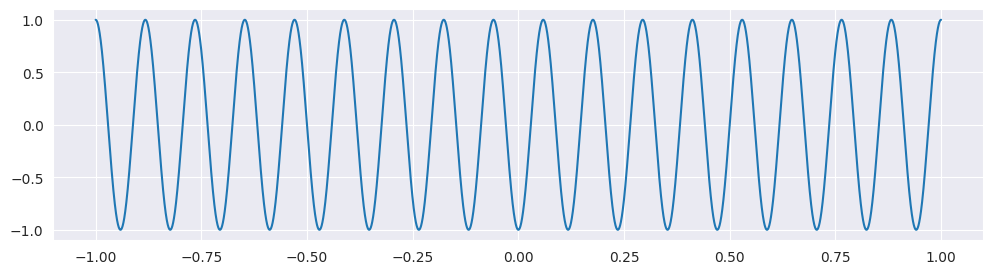

In [14]:
# Setup space in pytorch
valid_x = torch.linspace(x_min, x_max, resolution)
delta_x = valid_x[1] - valid_x[0]
# delta_x = 1

def potential(x, phase=0):
    return -1 * np.cos(.5*number_of_wells*np.pi*(x_max-x_min)*x+phase)

plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), potential(valid_x.cpu()))

We can numerically estimate the energy levels by solving the time independent hamiltonian $H\ket{\psi} = E \ket{\psi}$ for the lowest eigenvalues. First we start by building the associated @hamiltonian :

In [15]:
def generate_hamiltonian(phase: torch.Tensor | float = torch.tensor(0)) -> torch.Tensor:

    momentum = 2 * torch.diag(torch.ones(resolution)) / delta_x**2 \
               - (
                       (
                               torch.diag(torch.ones(resolution - 1), diagonal=1)
                               + torch.diag(torch.ones(resolution - 1), diagonal=-1)
                               + torch.diag(torch.ones(1), diagonal=resolution-1)
                               + torch.diag(torch.ones(1), diagonal=1-resolution)
                       ) / delta_x**2
               )
    trigonometric_potential = 100 * torch.diag(-1 * torch.cos(.5 * number_of_wells * np.pi*(x_max-x_min)*valid_x + phase))
    return momentum + trigonometric_potential

hamiltonian = generate_hamiltonian()

With the @hamiltonian built, we can numerically extract the lower level eigenvectors/eigenvalues:

In [ ]:
eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
eigenvalues = eigenvalues[:number_of_energy_levels]
eigenvectors = torch.transpose(eigenvectors, dim0=0, dim1=1)[:number_of_energy_levels]

fig, axes = plt.subplots(number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(number_of_energy_levels)

for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors)):
    axes[i].plot(valid_x.cpu().numpy(), np.real(vector.cpu().numpy()), label=f"Real")
    axes[i].plot(valid_x.cpu().numpy(), np.imag(vector.cpu().numpy()), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

This allows us to observe the energy levels. It is currently unclear why there is a "lone" constant ground state.

Currently unclear:
- #TODO: Check why we have a "lone" fixed solution.
- #TODO: Understand why the energy bands only have pairs of states, rather than a near continuum, as I increase the number of wells

<BarContainer object of 73 artists>

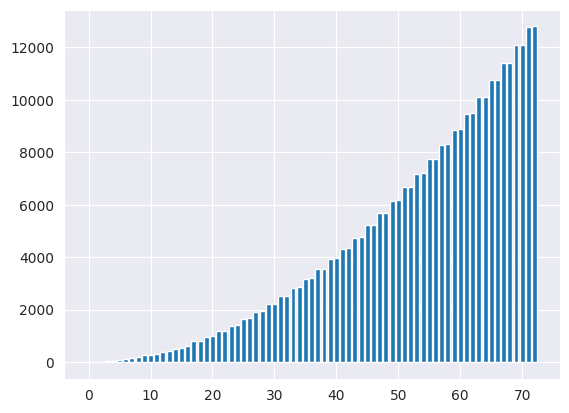

In [6]:
plt.bar(range(len(eigenvalues)), eigenvalues.cpu())

# Handling unstability

We get unsatisfactory numerical results as $P^2$, numerically, is orders of magnitude larger than $V(X)$. In particular, as our spatial resolution increases, the values inside our $P^2$ term increase as $\frac{1}{\Delta x^2}$, so that we no longer obtain good results. We can solve this by transforming our spacial coordinate accordingly. In particular, letting $z=k\tilde{x}$, we get $H=\frac{\hbar \omega}{2} ( - k^2 \frac{\partial ^2}{\partial z ^2}  + k^{-2} z^2 )$, with $z$ varying between $\pm k$. This means that the potential is in the interval $\pm 1$, whereas the kinetic term is in $\pm k^2 ( \Delta \tilde{x} )^{-2}$. Using $k=\Delta \tilde{x}$ we hope to balance out the two terms

In [7]:
k:int = number_of_wells

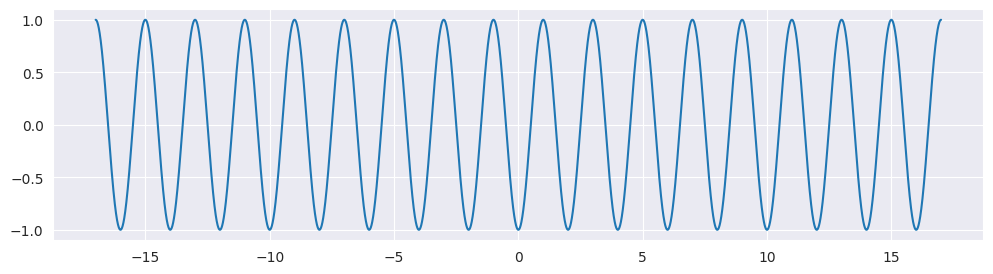

In [8]:
# Setup space in pytorch
valid_x = torch.linspace(x_min * k, x_max * k, resolution)
delta_x = valid_x[1] - valid_x[0]
# delta_x = 1

def potential(x, phase=0):
    return -1 * np.cos(np.divide(.5, k)*number_of_wells*np.pi*(x_max-x_min)*x+phase)

plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), potential(valid_x.cpu()))

In [9]:
def generate_hamiltonian(phase: torch.Tensor | float = torch.tensor(0)) -> torch.Tensor:

    momentum = 2 * torch.diag(torch.ones(resolution)) / delta_x \
               - (
                       (
                               torch.diag(torch.ones(resolution - 1), diagonal=1)
                               + torch.diag(torch.ones(resolution - 1), diagonal=-1)
                               + torch.diag(torch.ones(1), diagonal=resolution-1)
                               + torch.diag(torch.ones(1), diagonal=1-resolution)
                       ) / delta_x
               )
    trigonometric_potential = 100 * torch.diag(-1 * torch.cos(np.divide(.5, k) * number_of_wells * np.pi*(x_max-x_min)*valid_x + phase))
    return momentum + trigonometric_potential

hamiltonian = generate_hamiltonian()

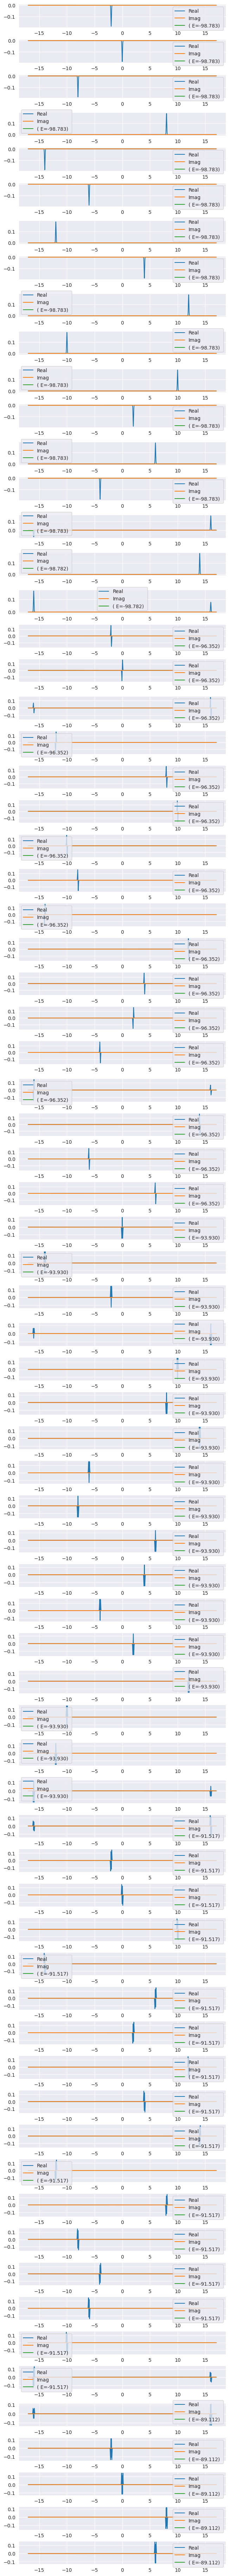

In [10]:
eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
eigenvalues = eigenvalues[:number_of_energy_levels]
eigenvectors = torch.transpose(eigenvectors, dim0=0, dim1=1)[:number_of_energy_levels]

fig, axes = plt.subplots(number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(number_of_energy_levels)

for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors)):
    axes[i].plot(valid_x.cpu().numpy(), np.real(vector.cpu().numpy()), label=f"Real")
    axes[i].plot(valid_x.cpu().numpy(), np.imag(vector.cpu().numpy()), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

<BarContainer object of 73 artists>

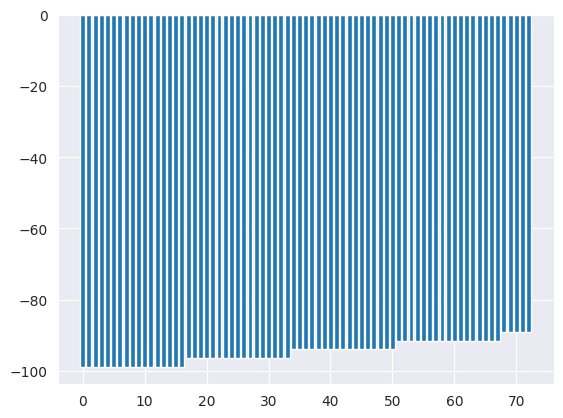

In [11]:
plt.bar(range(len(eigenvalues)), eigenvalues.cpu())